# Provasi Matteo (782922)

# Assignment 1

## Consegna
<br>
<font size=3>
    
 
1. Trovare l'omografia (trasformazione che può essere rappresentata come una matrice di rotazione/traslazione, permette di distorcere alcune coordinate di input o un'intera immagine seguendo determinate regole, nel nostro caso modificare l'immagine di sinistra per far sì che sia combaciata con quella di destra) che descrive la trasformazione tra i due set di punti.
2. Applicare l'omografia.
3. Integrare la seconda immagine.
<br>

## Librerie

In [1]:
import numpy as np
import cv2 as cv 
import imutils
import os
from matplotlib import pyplot as plt
from numpy import array
from PIL import Image


os.chdir("C:\\path\\")

## Caricamento immagini

In [2]:
# Dimensione dei plot
plt.rcParams['figure.figsize'] = [12, 6]

<font size=3>
Con la funzione <i>imread</i> sono caricate le immagini presenti nella cartella. Le successive righe con le funzioni <i>split</i> e <i>merge</i> permettono di redefinire i canali colore dell'immagine. Questo è necessario in quanto la libreria <b>cv2</b> utilizza i canali del rosso e del blu invertiti rispetto a <b>matplotlib</b> che è la libreria utilzzata per visualizzare a schermo l'immagine. Senza questa correazione i colori risulterebbero invertiti.
<br>
Viene creato un subplot per poter mostrare le due immagini affiancate.
<br>

Text(0.5,1,'Right picture')

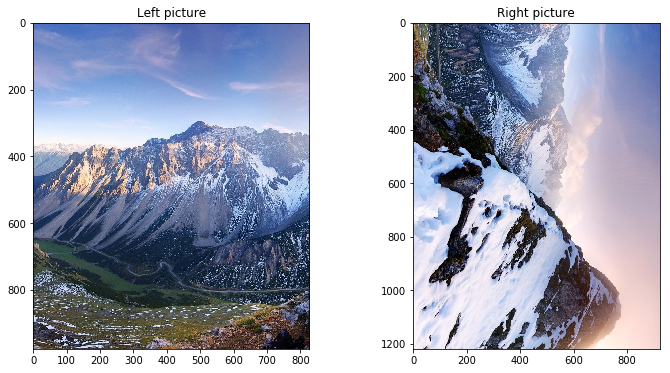

In [3]:
# Immagine 1
p1 = cv.imread('Part 1.png')
b,g,r = cv.split(p1)
p1 = cv.merge([r,g,b]) #Si sistemano i canali colore
fig = plt.figure()
fig.add_subplot(1, 2, 1) #Subplot per poter mostrare entrambe le immagini affiancate
plt.imshow(p1, cmap='gray')
plt.title('Left picture')


# Immagine 2
p2 = cv.imread('Part 2b.png')
b,g,r = cv.split(p2)
p2 = cv.merge([r,g,b])
fig.add_subplot(1, 2, 2)
plt.imshow(p2, cmap='gray')
plt.title('Right picture')

## Punti di interesse

<font size=3>
Viene inizializzato il costruttore <i>sift</i> a cui viene applicata la funzione  <i>detectAndCompute</i> che permette di individuare i keypoints di un'immagine. Questi punti di interesse sono utili nel lavoro di image stitching in quanto sono invarianti per distorsione dell'immagine (rotazioni, cambio di dimensioni...); sfruttando la porzione in comune delle immagini, questi punti aiutano a capire come devono essere ricucite i file.
<br>

In [4]:
sift = cv.xfeatures2d.SIFT_create()
(kps1, features1) = sift.detectAndCompute(p1, None)
(kps2, features2) = sift.detectAndCompute(p2, None)

print("I punti di interesse della foto a sinistra sono %s e quelli dell'immagine a destra sono %s" %(len(kps1), len(kps2)))

I punti di interesse della foto a sinistra sono 5462 e quelli dell'immagine a destra sono 7542


<font size=3>
La funzione <i>BFMatcher</i> permette di trovare le coppie di keypoints nelle due immagini più vicini fra loro. Il parametro <i>crossCheck=True</i> applica la tecnica dei <i>k</i> vicini più vicini (knnMatch).

In [7]:
bf = cv.BFMatcher(crossCheck=True)
matches = bf.match(features1, features2)

matches = sorted(matches, key = lambda x:x.distance)

In [32]:
#Punti di match con la distanza minore
[matches[i].distance for i in range(5)]

[6.928203105926514, 8.0, 8.5440034866333, 8.66025447845459, 9.219544410705566]

<font size=3>
Attraverso la funzione <i>drawMatches</i> sono rappresentati i punti di interesse delle due immagini e le rette che congiungono i primi 51 keypoints più vicini (matches[0:50] ordinata in precedenza).

Text(0.5,1,'Principali punti di interesse')

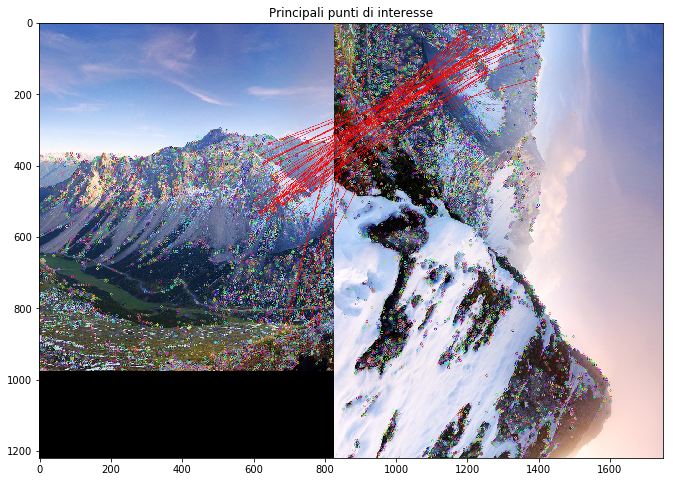

In [41]:
#Visualizzazione grafica dei punti di interesse con il corrispettivo match
result = cv.drawMatches(p1, kps1, p2, kps2, matches[0:50], None, matchColor = [255, 0, 0])
plt.imshow(result)
plt.title('Principali punti di interesse')

## Omografia

<font size=3>
Sono estratte le posizioni dei keypoints nelle due immagini e sono utilizzati come input per creare l'omografia. L'output della funzione <i>findHomography</i> è una matrice $3x3$ di traslo-rotazione; applicata alla seconda immagine permetterà di trovare le esatte corrispondenze per ricucirla alla prima.  

In [27]:
#Si creano numpy array di punti che serviranno per ottenere la matrice per l'omografia
dst = np.float32([kps1[matches[m].queryIdx].pt for m in range(len(matches))]).reshape(-1,1,2)
src = np.float32([kps2[matches[m].trainIdx].pt for m in range(len(matches))]).reshape(-1,1,2)

#Calcolo dell'omografia
H, masked = cv.findHomography(src, dst, cv.RANSAC, 5.0)
print(H)

[[-7.78532682e-04  1.00007558e+00  5.95380149e+02]
 [-9.99977247e-01 -9.52311541e-04  8.98044552e+02]
 [ 7.79012855e-08  6.00934461e-09  1.00000000e+00]]


## Stitching

<font size=3>
Applicando l'omografia si riposiziona l'immagine di destra (Warped Image) che sarà poi unita alla prima immagine utilizzando come riferimento le coordinate dei punti di interesse (dst) trovati precedentemente.

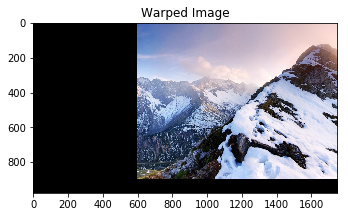

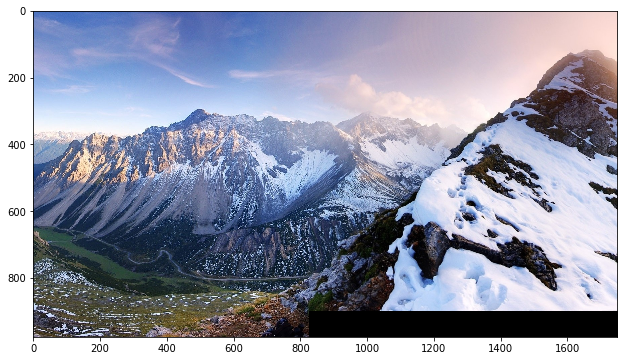

In [26]:
#Applicando la matrice dell'omografia di ottiene l'immagine, di destra, che dovrà essere cucita all'altra
dst = cv.warpPerspective(p2,H,(p1.shape[1] + p2.shape[1], p1.shape[0]))
plt.subplot(122),plt.imshow(dst),plt.title('Warped Image')
plt.show()
plt.figure()

#Cucitura e visualizzazione dei risultati
dst[0:p1.shape[0], 0:p1.shape[1]] = p1
cv.imwrite('resultant_stitched_panorama.jpg',dst)
plt.imshow(dst)
plt.show()